<a href="https://colab.research.google.com/github/selina20/AIFinance/blob/main/klay_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
import datetime

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/klay.csv',header=0)
data.head()

,Date,Open,High,Low,Close,Volume,Market Cap
0,30-Mar-20,111.50,137.19,111.31,136.68,475347115.0,0.0
1,31-Mar-20,137.83,147.27,137.10,142.59,353269979.0,0.0
2,01-Apr-20,141.99,143.42,129.63,135.79,296125827.0,0.0
3,02-Apr-20,138.54,220.21,118.81,143.48,463654971.0,0.0
4,03-Apr-20,142.38,143.29,137.56,139.84,235777252.0,0.0


In [32]:
high_prices = data['High'].values
low_prices = data['Low'].values
mid_prices = (high_prices + low_prices)/2

In [33]:
seq_len = 50
sequence_length = seq_len + 1

result = []
for index in range(len(mid_prices) - sequence_length):
    result.append(mid_prices[index: index + sequence_length])

In [34]:
def normalize_windows(data):
    normalized_data = []
    for window in data:
        normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalized_data.append(normalized_window)
    return np.array(normalized_data)

result = normalize_windows(result)

# split train and test data
row = int(round(result.shape[0] * 0.9))
train = result[:row, :]
np.random.shuffle(train)

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape

((511, 50, 1), (57, 50, 1))

In [35]:
model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(50, 1)))

model.add(LSTM(64, return_sequences=False))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='rmsprop')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 64)                29440     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________


In [36]:
start_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')

model.fit(x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=10,
    epochs=20,
    callbacks=[
        TensorBoard(log_dir='logs/%s' % (start_time)),
        ModelCheckpoint('./models/%s_eth.h5' % (start_time), monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='auto')
])

Epoch 1/20
52/52 [==============================] - ETA: 0s - loss: 0.3765
Epoch 00001: val_loss improved from inf to 0.00523, saving model to ./models/2021_12_09_13_52_50_eth.h5
52/52 [==============================] - 7s 63ms/step - loss: 0.3765 - val_loss: 0.0052 - lr: 0.0010
Epoch 2/20
51/52 [============================>.] - ETA: 0s - loss: 0.1477
Epoch 00002: val_loss did not improve from 0.00523
52/52 [==============================] - 2s 45ms/step - loss: 0.1474 - val_loss: 0.0144 - lr: 0.0010
Epoch 3/20
51/52 [============================>.] - ETA: 0s - loss: 0.1227
Epoch 00003: val_loss did not improve from 0.00523
52/52 [==============================] - 2s 46ms/step - loss: 0.1224 - val_loss: 0.0069 - lr: 0.0010
Epoch 4/20
51/52 [============================>.] - ETA: 0s - loss: 0.1016
Epoch 00004: val_loss improved from 0.00523 to 0.00484, saving model to ./models/2021_12_09_13_52_50_eth.h5
52/52 [==============================] - 2s 46ms/step - loss: 0.1014 - val_loss: 0.

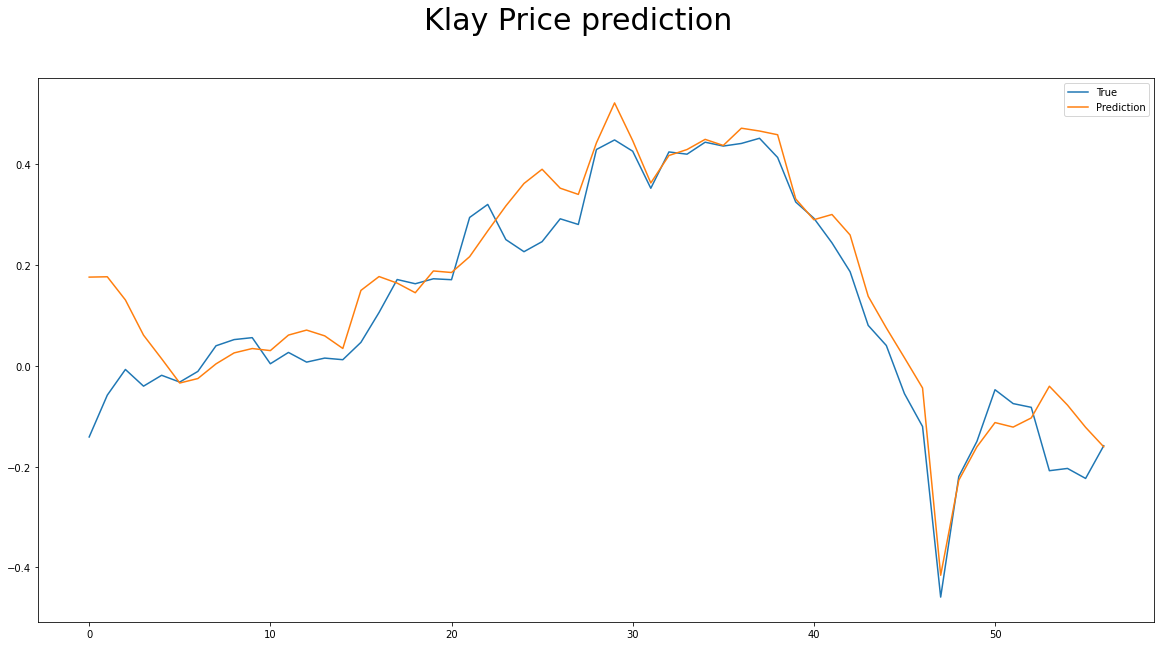

In [44]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
fig.suptitle('Klay Price prediction', fontsize=30)
ax.legend()
plt.show()